In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models

## Establishing baseline accuracy
Using ResNet50, pretrained on ImageNet-1K, with all layers frozen.

What are the Top-k accuracies for:
- keyboard
- microwave
- mobile phone
- mouse
- player
- printer
- television
- washing machine

Note that {battery, PCB} cannot be tested since these categories do not appear in ImageNet-1K.

#### Load the pretrained model

In [2]:
model = ResNet50(weights='imagenet')

#### Evaluate top-k accuracies across the test set

In [3]:
# Dictionary, mapping our categories to appropriate ImageNet-1K categories
category_mapping = {
    "Keyboard": ["computer_keyboard", "typewriter_keyboard", "space_bar"],
    "Microwave": ["microwave"],
    "Mobile": ["cellular_telephone", "hand-held_computer", "iPod", "remote_control", "CD_player", "tape_player", "cassette_player", "hard_disc"],
    "Mouse": ["mouse"],
    "Player": ["cassette", "cassette_player", "tape_player", "CD_player"],
    "Printer": ["printer", "photocopier"],
    "Television": ["television", "screen", "monitor", "entertainment_center", "home_theater"],
    "Washing Machine": ["washer"]
}

results = []
total_correct = 0
total_samples = 0
for category, acceptable_labels in category_mapping.items():
    
    test_dir = "dataset2/test/" + category
    
    # Load all images into a list
    imgs = []
    for fname in os.listdir(test_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(test_dir, fname)
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            imgs.append(x)

    # Convert to array and preprocess
    x = np.array(imgs)
    x = preprocess_input(x)
    
    # Make predictions and evaluate top-k accuracies
    for k in [1,3,5]:
        preds = model.predict(x, batch_size=32, verbose=0)
        decoded_preds = decode_predictions(preds, top=k)
        correct = sum(any(pred[1] in acceptable_labels for pred in sample) for sample in decoded_preds)
        total = len(decoded_preds)
        # print(f"{category:20} | Top-{k} accuracy: {correct:2}/{total} = {correct/total:7.2%}")
        results.append({
            "Category": category,
            "Top-k": k,
            "Accuracy": correct/total
        })
        if k==1:
            total_correct += correct
            total_samples += total

df = pd.DataFrame(results)

##### Results (Table)

In [4]:
print(f"Overall accuracy (test set): {total_correct}/{total_samples} = {total_correct/total_samples:.3f}")

Overall accuracy (test set): 164/292 = 0.562


In [5]:
print(df.pivot(index="Category", columns="Top-k", values="Accuracy"))

Top-k                   1         3         5
Category                                     
Keyboard         0.325000  0.600000  0.675000
Microwave        0.604651  0.813953  0.930233
Mobile           0.190476  0.285714  0.404762
Mouse            0.707317  0.756098  0.804878
Player           0.566667  0.833333  0.900000
Printer          0.866667  0.966667  0.966667
Television       0.777778  0.916667  0.916667
Washing Machine  0.566667  0.766667  0.766667


##### Results (Bar Chart)

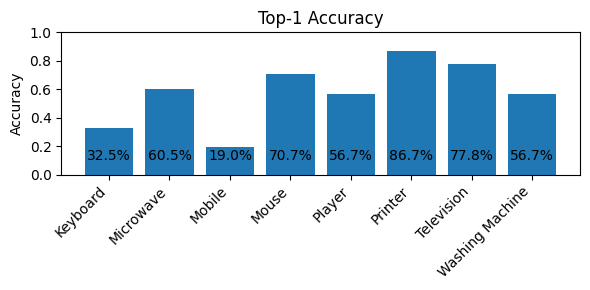

In [6]:
import matplotlib.pyplot as plt

k = 1

df_toplot = df[df["Top-k"] == k]

plt.figure(figsize=(6, 3))
plt.bar(df_toplot["Category"], df_toplot["Accuracy"])
plt.ylabel("Accuracy")
plt.title(f"Top-{k} Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)

# Optionally add labels on top of bars
for i, acc in enumerate(df_toplot["Accuracy"]):
    plt.text(i, 0.1, f"{acc:.1%}", ha="center")

plt.tight_layout()
plt.show()

## Transfer learning

Use ResNet50 with transfer learning.

Base model: ResNet50, pretrained on ImageNet-1K, with all layers frozen. Just added a custom classification layer on top (for our e-waste categories).

#### Load train/val/test datasets

In [7]:
img_size = (224,224)   # resize to 224x224 even if dataset is 150x150
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset2/train",
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset2/val",
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset2/test",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print(class_names)

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   =   val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  =  test_ds.map(lambda x, y: (preprocess_input(x), y))

Found 3123 files belonging to 13 classes.
Found 377 files belonging to 13 classes.
Found 382 files belonging to 13 classes.
['Battery', 'Camera', 'Keyboard', 'Laptop', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Smartwatch', 'Television', 'Washing Machine']


#### Create the ResNet50-based model for transfer learning

In [8]:
# Base layer w/ frozen weights
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

# Add classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 13)                26637     
                                                                 
Total params: 23,614,349
Trainable params: 26,637
Non-trainable params: 23,587,712
_________________________________________________________________


#### Train the model

In [9]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy", # if we only care about getting the "right" answer, should stick with scce. If top-k is acceptable, should use cce.
              metrics=["accuracy"])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5, verbose=1)

print("Test accuracy:", model.evaluate(test_ds)[1])

Epoch 1/5
98/98 [==============================] - 9s 69ms/step - loss: 1.1122 - accuracy: 0.6615 - val_loss: 0.2967 - val_accuracy: 0.9178
Epoch 2/5
98/98 [==============================] - 6s 60ms/step - loss: 0.3247 - accuracy: 0.8959 - val_loss: 0.2337 - val_accuracy: 0.9284
Epoch 3/5
98/98 [==============================] - 6s 60ms/step - loss: 0.2139 - accuracy: 0.9235 - val_loss: 0.2066 - val_accuracy: 0.9443
Epoch 4/5
98/98 [==============================] - 6s 61ms/step - loss: 0.1823 - accuracy: 0.9392 - val_loss: 0.1900 - val_accuracy: 0.9390
Epoch 5/5
12/12 [==============================] - 1s 54ms/step - loss: 0.2278 - accuracy: 0.9346
Test accuracy: 0.9345549941062927


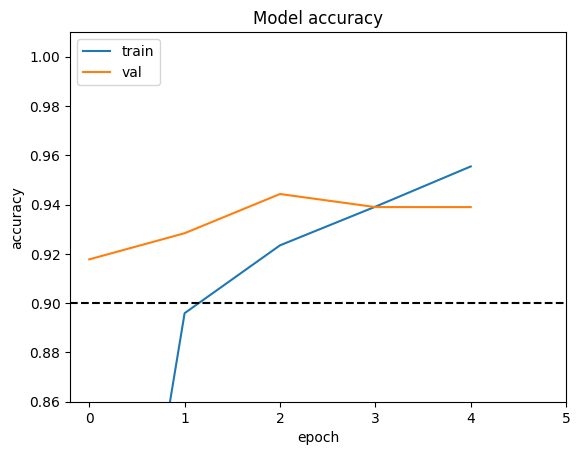

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=0.90, color='k', linestyle='--')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(len(history.history['accuracy'])+1))
plt.ylim((0.86,1.01))

plt.show()

#### Evaluate top-k accuracies across the test set

In [11]:
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds, verbose=0)

results = []

for i, class_name in enumerate(class_names):
    idx = np.where(y_true == i)[0] # indices of samples in this class
    total = len(idx) # total number of samples in this class
    preds = y_pred_probs[idx] # model predictions for this class
    
    for k in [1,3,5]:
        top_k = np.argsort(preds)[:, -k:]   # top-k predicted indices
        correct = np.sum([i in row for row in top_k])
        acc = correct / total
        results.append({"Category": class_name, "Top-k": k, "Accuracy": acc})

df = pd.DataFrame(results)

##### Results (Table)

In [12]:
print(df.pivot(index="Category", columns="Top-k", values="Accuracy"))

Top-k                   1         3         5
Category                                     
Battery          0.933333  0.966667  0.966667
Camera           0.500000  0.600000  0.800000
Keyboard         1.000000  1.000000  1.000000
Laptop           0.600000  0.700000  0.700000
Microwave        0.883721  1.000000  1.000000
Mobile           1.000000  1.000000  1.000000
Mouse            0.975610  1.000000  1.000000
PCB              0.933333  1.000000  1.000000
Player           0.933333  1.000000  1.000000
Printer          1.000000  1.000000  1.000000
Smartwatch       0.900000  1.000000  1.000000
Television       0.944444  1.000000  1.000000
Washing Machine  0.966667  1.000000  1.000000


In [13]:
acc_val = model.evaluate(val_ds, verbose=0)[1]
acc_test = model.evaluate(test_ds, verbose=0)[1]
print(f"Overall accuracy (val set): {acc_val:.3f}")
print(f"Overall accuracy (test set): {acc_test:.3f}")

Overall accuracy (val set): 0.939
Overall accuracy (test set): 0.935


##### Results (Bar Chart)

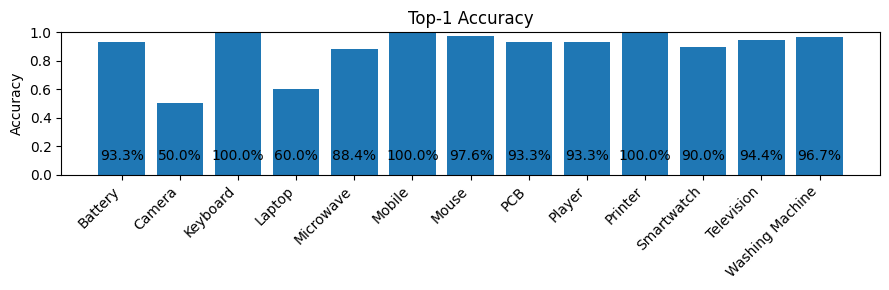

In [14]:
k = 1
df_toplot = df[df["Top-k"] == k]

plt.figure(figsize=(9, 3))
plt.bar(df_toplot["Category"], df_toplot["Accuracy"])
plt.ylabel("Accuracy")
plt.title(f"Top-{k} Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)  # accuracy between 0 and 1

# Optionally add labels on top of bars
for i, acc in enumerate(df_toplot["Accuracy"]):
    plt.text(i, 0.1, f"{acc:.1%}", ha="center")

plt.tight_layout()
plt.show()

#### Results - Confusion matrix

NB: this will be visually misleading w/ dataset2 (classes are imbalanced)

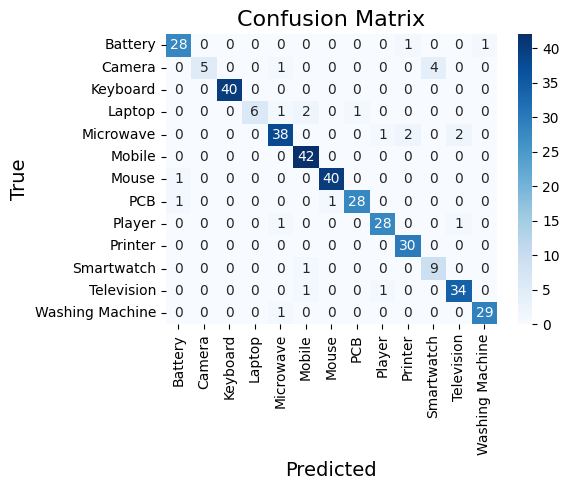

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
ax.xaxis.set_ticklabels(class_names, fontsize=10, rotation=90)
ax.yaxis.set_ticklabels(class_names, fontsize=10, rotation=0)

plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

#### Playing around - what's it predict some random image is?

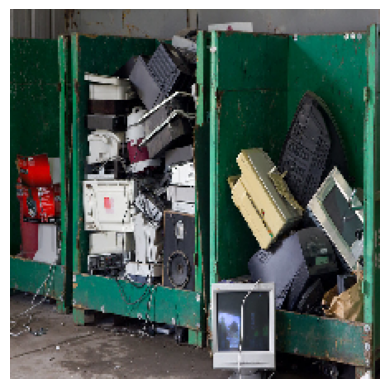

[[('<unknown>', 'PCB', 0.9970698356628418),
  ('<unknown>', 'Television', 0.0009577320888638496),
  ('<unknown>', 'Mobile', 0.000766279932577163),
  ('<unknown>', 'Battery', 0.0006063871551305056),
  ('<unknown>', 'Printer', 0.0003472300013527274)]]

In [16]:
def decode_predictions_custom(preds, class_names, top=5):
    """
    Functionally identical to tensorflow.keras.applications.resnet50.decode_predictions.
    But this also works using the modified NN structure.
    """
    decoded = []
    for sample in preds:
        top_idx = sample.argsort()[-top:][::-1]  # top indices descending
        sample_decoded = []
        for i in top_idx:
            id_str = f"<unknown>" # dummy ID for features (not used, just put it there so output has the required shape)
            label = class_names[i]
            score = float(sample[i])
            sample_decoded.append((id_str, label, score))
        decoded.append(sample_decoded)
    return decoded

x = image.load_img('C:/Users/conor/Downloads/ewaste.jpg', target_size=(224, 224))
plt.imshow(x)
plt.axis('off')
plt.show()

k=5
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)  # add batch dimension
x = preprocess_input(x)
preds = model.predict(x, batch_size=32, verbose=0)
decoded_preds = decode_predictions_custom(preds, class_names, top=k)
decoded_preds